TODO:
* remove packages from notebook that we dont use
* Do a good implementation of Hyperparameter search/optimization by following professional advices/techniques

# **Image Classification on CIFAR10:**                                         A Survey of different deep learning architectures

In this notebook we will perform **image classification** on the **CIFAR-10 dataset** as a first step into the realm of **computer vision (CV)**. While such a task corresponds to a very simple problem for nowadays standards, we will use it to learn and put into practice several concepts that are common to many other tasks in CV. To this end, we will perform a survey of different architectures from basics to more advance ones. At the same time we increase the model's complexity, we introduce more sophisticated and modern concepts regarding parameter initialization, network regularization and stabilization, and optimization, among others.


We begin by loading the **CIFAR-10** dataset and performing a small exploratory data analysis. We split the data into **train**, **validation** and **test** sets being careful of keeping the balance among classes in each set. We then introduce the **pre-processing transformations** that will be used along the notebook, including one with **data augmention**.

We begin our model survey by exploring the most basic designs, corresponding to **fully connected networks**. We check quickly how a simple **linear** model performs and then move to a **3-layer dense network**.

**Classical Convolutional Neural Networks (CNNs)** are then inspected: **LeNet-5**, **AlexNet**, and **VGG**. As the models start becoming more complex, in this section, we take the opportunity to introduce regularization methods, such as **L2 regularization** and **dropout**, as well as stabilization techniques, including **batch normalization** and **He weight initialization**.

We finish the survey by testing two modern CNN architectures: **ResNet** and **DenseNet**. Due to the complexity of these models and our computational limitations, we do not them from scratch but use **transfer learning** by loading **pre-trained models** and **fine-tunning** them with our dataset. For DenseNet, being our last model, we introduce **data augmentation**, **learning rate decay**, and change the SGD optimizer we have been using so far for the more modern **Adam optimizer**.


We then carry on a small analysis of how the best found model performs on the unseen testset, by inspecting the **confussion matrix** and displaying explicit **misclassified examples**. The notebook finalizes with a conclusion section.

**[IMPROVE]**

Along the notebook we will make heavy use of many local files and modules:
* `training_app.py`: contains the class `CIFARTrainingApp`, the main module of the repository, used to train, validate and save the different models.
* `models.py`: contains our own implementations of some of the deep-learning models used here.
* `dataset.py`: contains a custom `CIFARDataset` class, which is a subclass of Pytorch's `Dataset` implementing the `__len__` and `__getitem__` methods suitable for our problem. The file also contains classes for pre-processing and data-augmentation transformations.
* `utils`: this folder contains some extra functions for loadind data, visualization, etc.

Apart from this (very) brief summary of the local scripts, we will not describe their functionalities in any more detail in this notebook. We invite the curious reader to check out the source code in **[TODO:Github](TODO:INSERT LINK)**!

## Packages

In [1]:
# built-in packages
from time import time
import datetime
import random
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm  # just to log fancy training progress bar

# save program's directory
cwd = os.getcwd()
if cwd == '/content':  # if we are in colab, we mount drive
  from google.colab import drive
  drive.mount('/content/drive')

  # change dir to where CIFAR10 app is located
  os.chdir("drive/MyDrive/CIFAR10_classifier/")
  cwd = os.getcwd()
elif 'drive' in cwd:  # already monted and changed dir
  pass
else:  # local machine case
  cwd = './'
print(f'Current working directory: {cwd}')

# local modules
from utils.util import load_data, split_train_val, set_seed, test_model, get_accuracy
from utils.visualization import show_data, plot_metrics
from dataset import CIFARDataset, CustomTransform
from models import Linear, Dense, LeNet5, AlexNet, AlexNetNorm, AlexNet1Fc, VGG16, ResNet50Wrapper, DenseNet121Wrapper
from training_app import CIFARTrainingApp

/usr/lib/python3/dist-packages/mpmath/ctx_mp_python.py:873: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if other is 0:
/usr/lib/python3/dist-packages/mpmath/ctx_mp_python.py:967: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if other is 0:
/usr/lib/python3/dist-packages/sympy/solvers/diophantine.py:3188: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if feasible is 1:  # it's prime and k == 2


Current working directory: ./


## CIFAR-10 dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour (3-channel) images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. It was collected by **Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton**. The 10 classes are given by

`['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']`

and they are mutually exclusive.

### Loading the Data

For this notebook we downloaded the dataset from the above link, stored in a local directory named `CIFAR10_data`, and loaded the train (50000 images) and test (10000 images) sets into local variables via the local function `load_data`. We name the former `data_train_raw` because we will then split it further into a *real* trainset and a validation set. The latter is used to perform hyperparameter and model search.

In [2]:
# load raw data
data_dir = os.path.join(cwd, 'CIFAR10_data/')
data_train_raw, data_test, classes = load_data(data_dir)

n_train_raw = len(data_train_raw['labels'])
n_test = len(data_test['labels'])

print(f'Train (raw) set length: {n_train_raw}')
print(f'Test set length: {n_test}')
print(f'Classes: {classes}')

Train (raw) set length: 50000
Test set length: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Data Exploration

Let's begin by picking a single example and studying some of its properties

type: <class 'numpy.ndarray'>, <class 'numpy.ndarray'>
shape: (32, 32, 3), (1,)
max and min image values: (255, 0)
label: [6], class: frog
mean and std image values: (103.45, 51.97)


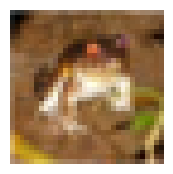

In [3]:
img_n = 0
img, label = data_train_raw['imgs'][img_n], data_train_raw['labels'][img_n]
print(f'type: {type(img)}, {type(label)}')
print(f'shape: {img.shape}, {label.shape}')
print(f'max and min image values: {(img.max(), img.min())}')
print(f'label: {label}, class: {classes[label[0]]}')
print(f'mean and std image values: {(round(img.mean(), 2), round(img.std(), 2))}')
plt.subplots(figsize=(10, 2))
plt.imshow(img)
plt.axis('off')
plt.show()

Now let's take a look at the datasets by showing some random images and their corresponding labels.

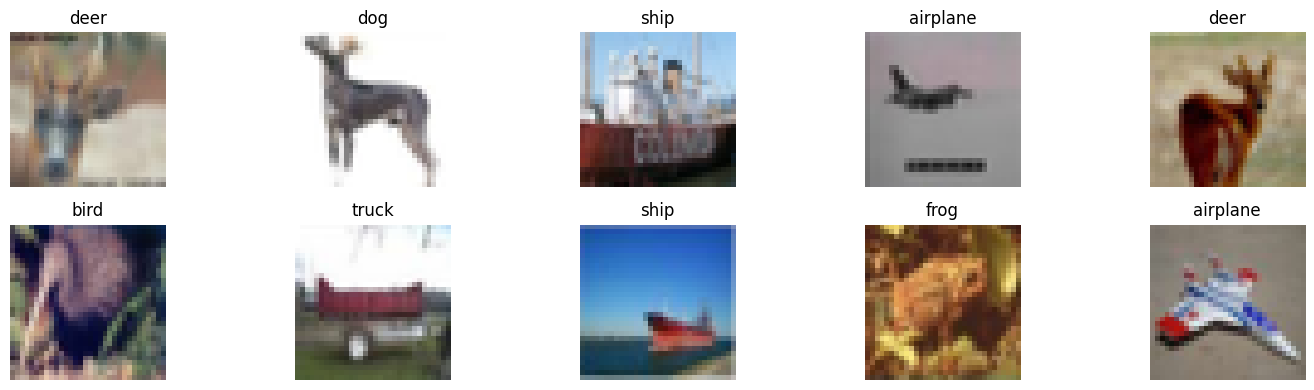

In [4]:
# random images from train dataset
indices_train_raw = np.random.randint(0, n_train_raw, size=10)
imgs = data_train_raw['imgs'][indices_train_raw]
labels = data_train_raw['labels'][indices_train_raw]
show_data(imgs, labels)

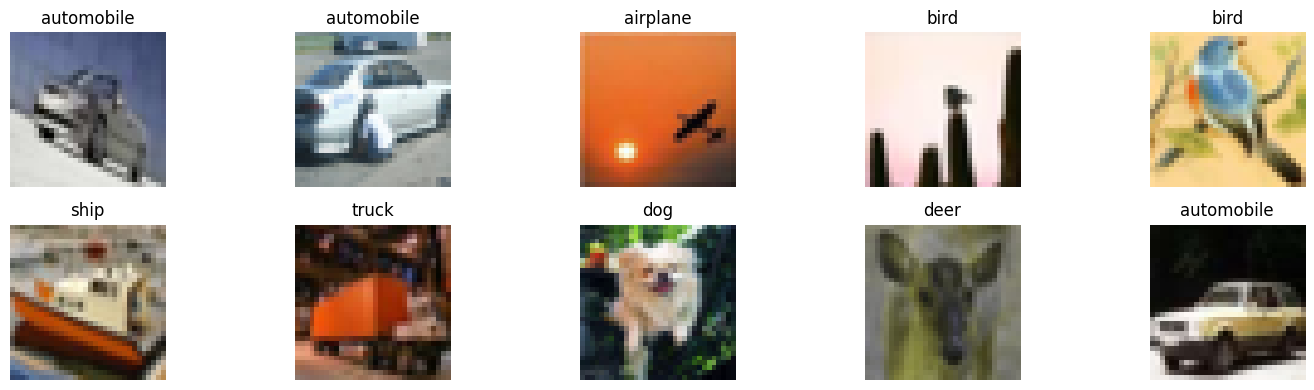

In [5]:
# random images from test set
indices_test = np.random.randint(0, n_test, size=10)
imgs = data_train_raw['imgs'][indices_test]
labels = data_train_raw['labels'][indices_test]
show_data(imgs, labels)

We now check whether the datasets are balanced or not by counting the number of images in each class.

In [6]:
counts = pd.DataFrame(index=classes, columns=['train_raw', 'test'])

for i, label in enumerate(classes):
  counts.loc[label]['train_raw'] = (data_train_raw['labels'] == i).sum()
  counts.loc[label]['test'] = (data_test['labels'] == i).sum()

counts

,train_raw,test
airplane,5000,1000
automobile,5000,1000
bird,5000,1000
cat,5000,1000
deer,5000,1000
dog,5000,1000
frog,5000,1000
horse,5000,1000
ship,5000,1000
truck,5000,1000


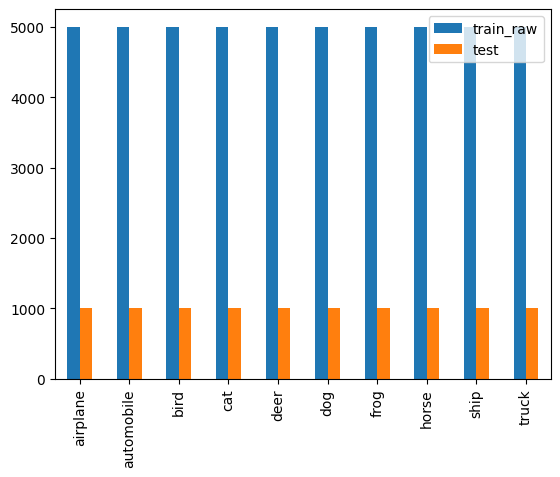

In [7]:
counts.plot.bar()
plt.show()

As we can see, both datasets are balanced, having the same number of images per class!

We now want to split the raw training set into a training set and validation set. By doing so, however, we must be careful to do it in a way that the validation set follows the same distribution as the test set. In this case, it boils down to force the validation set to be balanced. This is taken care by the local function `split_train_val`.

We also take the opportunity to define a small dataset, which is nothing but a very small (balanced) subsector of the training set, used for debugging or running consistency checks.

In [8]:
val_size = 5000
data_train, data_val = split_train_val(data_train_raw, val_size)
n_train = len(data_train['labels'])
n_val = len(data_val['labels'])
# consistency checks for data sizes
print(n_val == val_size, n_train == n_train_raw - n_val)

n_small = 500
_, data_small = split_train_val(data_train, n_small)

True True


In [9]:
counts = pd.DataFrame(index=classes, columns=['train', 'val', 'test', 'small'])

for i, label in enumerate(classes):
  counts.loc[label]['train'] = (data_train['labels'] == i).sum()
  counts.loc[label]['val'] = (data_val['labels'] == i).sum()
  counts.loc[label]['test'] = (data_test['labels'] == i).sum()
  counts.loc[label]['small'] = (data_small['labels'] == i).sum()

counts

,train,val,test,small
airplane,4500,500,1000,50
automobile,4500,500,1000,50
bird,4500,500,1000,50
cat,4500,500,1000,50
deer,4500,500,1000,50
dog,4500,500,1000,50
frog,4500,500,1000,50
horse,4500,500,1000,50
ship,4500,500,1000,50
truck,4500,500,1000,50


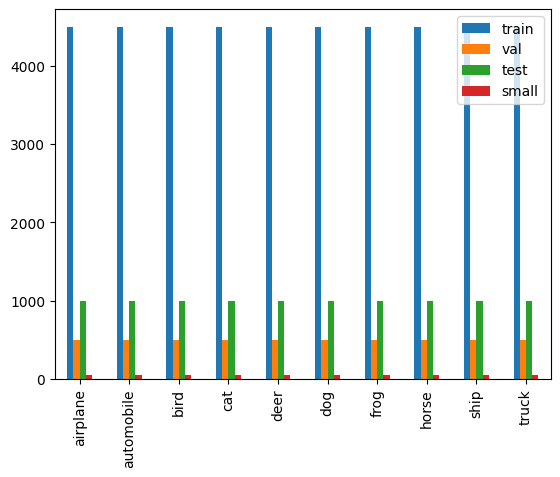

In [10]:
counts.plot.bar()
plt.show()

### Preprocessing

Before jumping into traning the models, we need to perform some small preprocessing transformations on the datasets.

We will use two of the most common transformations all over the notebook: **rescaling**, and **standardization**. They help us preventing from propagating big numbers during training and bring all examples to have a similar distribution.

For rescaling we bring images from the original range \[0, 255\] to \[0, 1\] and convert them to `Tensor` objects. We then use per-image and per-channel standardization by substracting a mean value and divide by the standard deviation (std). We do it **feature-wise**, meaning that the mean and std statistics are calculated across the entire training dataset. (It is important to remember that the values used for preprocessing cannot contain information about the test or validation set!) These values are stored in the following local variables for later use

In [11]:
# cifar10 trainset statistics for standarization
train_mean = [0.491, 0.482, 0.447]
train_std = [0.128, 0.126, 0.153]

Some networks require the input to be of a specific shape and so, apart from the previous trasformations, we need to **resize** the images before rescaling and standardizing. Additionally, in some cases we will use pre-trained models, and so the mean and std values used for standardization will correspond to those from another training dataset (not CIFAR-10). In particular, we use those for ImageNet

In [12]:
# imagenet trainset statistics for standarization
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

All these preprocessing steps are encoded in the class `CustomTransform`, and their variations are controlled by choosing different parameters. In what follows we define the transformations we will use across the notebook and show some transformed images.

**[ADD AUGMENTATION]**

In [13]:
trans_32cifar = CustomTransform(train_mean, train_std, resize=None)
trans_227cifar = CustomTransform(train_mean, train_std, resize=227)
trans_224cifar = CustomTransform(train_mean, train_std, resize=224)
trans_224imagenet = CustomTransform(imagenet_mean, imagenet_std, resize=224)
trans_224imagenet_aug = CustomTransform(imagenet_mean, imagenet_std, resize=224, use_augmentation=True)

type: <class 'numpy.ndarray'>
shape: (32, 32, 3)
max and min values: (182, 26)
mean and std values: (110.13, 27.98)


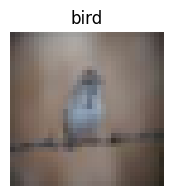

In [14]:
# show image before transformation
img_n = 0
img, label = data_train['imgs'][img_n], data_train['labels'][img_n]
print(f'type: {type(img)}')
print(f'shape: {img.shape}')
print(f'max and min values: {(img.max(), img.min())}')
print(f'mean and std values: {(round(img.mean(), 2), round(img.std(), 2))}')
show_data(img, label)

type: <class 'torch.Tensor'>
shape: torch.Size([1, 3, 32, 32])
max and min values: (tensor(1.7433), tensor(-2.7672))
mean and std values: (tensor(-0.3100), tensor(0.7900))


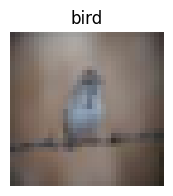

In [15]:
# show image after normalization transformation
img_t, label_t = trans_32cifar(img, label)
# add artificial batch axis
img_t = img_t.unsqueeze(0)
label_t = label_t.unsqueeze(0)
print(f'type: {type(img_t)}')
print(f'shape: {img_t.shape}')
print(f'max and min values: {(img_t.max(), img_t.min())}')
print(f'mean and std values: {(np.round(img_t.mean(), 2), np.round(img_t.std(), 2))}')

# requires stats to undo the transformation (required for plotting!)
show_data(img_t, label_t, mean=trans_32cifar.norm_mean, std=trans_32cifar.norm_std)

type: <class 'torch.Tensor'>
shape: torch.Size([1, 3, 227, 227])
max and min values: (tensor(1.7433), tensor(-2.3003))
mean and std values: (tensor(-0.1400), tensor(0.6800))


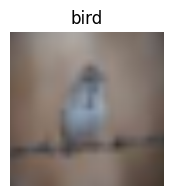

In [16]:
# show image after normalization + resizing transformation
img_t, label_t = trans_227cifar(img, label)
img_t = img_t.unsqueeze(0)
label_t = label_t.unsqueeze(0)
print(f'type: {type(img_t)}')
print(f'shape: {img_t.shape}')
print(f'max and min values: {(img_t.max(), img_t.min())}')
print(f'mean and std values: {(np.round(img_t.mean(), 2), np.round(img_t.std(), 2))}')

# requires stats to undo the transformation (required for plotting!)
show_data(img_t, label_t, mean=trans_227cifar.norm_mean, std=trans_227cifar.norm_std)

type: <class 'torch.Tensor'>
shape: torch.Size([1, 3, 224, 224])
max and min values: (tensor(1.3677), tensor(-1.4158))
mean and std values: (tensor(-0.0100), tensor(0.4400))


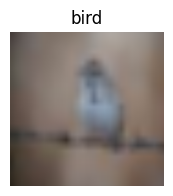

In [17]:
# show image after normalization + resizing + augmentation transformation
img_t, label_t = trans_224imagenet_aug(img, label)
img_t = img_t.unsqueeze(0)
label_t = label_t.unsqueeze(0)
print(f'type: {type(img_t)}')
print(f'shape: {img_t.shape}')
print(f'max and min values: {(img_t.max(), img_t.min())}')
print(f'mean and std values: {(np.round(img_t.mean(), 2), np.round(img_t.std(), 2))}')

# requires stats to undo the transformation (required for plotting!)
show_data(img_t, label_t, mean=trans_224imagenet_aug.norm_mean, std=trans_224imagenet_aug.norm_std)

## Fully Connected Networks

In this section we study the simplest neural network architectures: a linear classifier and a 3-layer, non-linear, fully-connected network.

Our main goal here is to show how these simple models perform to compare them later with more advanced achitectures. Because of this, we do not carry on any hyperparameter search, nor look for the best weight initialization or optimizer. We stick to **Stochastic Gradient Descent (SGD)** with momentum as the optimizer, and we do not use regularization. We may change the learning rate from one model to another. For preprocessing we use standardization without resizing.

Of course, it may be possible to achieve better performance when trying different configurations. However, the claim is that an exhaustive hyperparameter search for these models will not give us better performance than the one obtained from an exhaustive hyperparameter search on the more complex ones coming next.

### Linear Classifier

Classification models aim to solve the problem of assigning a given $D$-dimensional input vector $x$ to one of $K$ discrete classes. This is achieved by separating the input space into regions via the so-called **decision boundaries**. When these boundaries are defined by linear functions of $x$, the models are said to be linear. Datasets that admit such separation are called **linearly separable**.

In our particular case, we have $K=10$ classes and the inputs are $D=32 \times 32 \times 3$ dimensional vectors, coming from flattening the input image. The problem is **highly non-linear** and so a linear classifier will perform poorly.

We can see this from a simple experiment: after training for 100 epochs, the model is not able to overfit even on the small traning set! It achieves only 74.23% of accuracy on the training set and 29.94% on the validation set.

When training on the real (bigger) training set the accuracy obviously drops, but it performs better on the validation set, which is what we really care about. After 30 epochs, the model achieves 48.21% on the training set and **42.84%** on the validation set. Even though this is not a huge rate, it is actually a remarkable achievement for just a simple linear classifier!

In [21]:
app_parameters = {'num_workers': 2,
                  'val_freq': 1,
                  'save_path': cwd + '/saved_models/linear',
                  'seed': 42}

hyperparameters = {'batch_size': 64,
                   'epochs': 30,
                   'model_parameters': {},
                   'optimizer_parameters': {'lr': 0.001, 'momentum': 0.9}}

design = {'model': Linear, 'criterion': nn.CrossEntropyLoss, 'optimizer': optim.SGD}

transformation = {'train': trans_32cifar, 'val': trans_32cifar}

training_app = CIFARTrainingApp(data_train,
                                data_val,
                                app_parameters,
                                hyperparameters,
                                transformation,
                                design)

print(f'\nModel: {training_app.model}')
n_parameters = np.sum([p.numel() for p in training_app.model.parameters()])
print(f'\nNumber of parameters: {n_parameters}\n')

print(f'\nCriterion: {training_app.criterion}')
print(f'\nOptimizer: {training_app.optimizer}')

Using cpu device
Random seed set as 42

Model: Linear(
  (fc): Linear(in_features=3072, out_features=10, bias=True)
)

Number of parameters: 30730


Criterion: CrossEntropyLoss()

Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


In [22]:
training_app.main(validate_bool=True, save_bool=True)

Loading data...

Start training with 704/79 batches (trn/val) of size 64 for 30 epochs



Epoch 1/30: 100%|█| 704/704 [00:05<00:00, 128.42it/s, Loss = 2.225, Acc = 12.50%

Val Loss: 2.083 Val Acc: 37.62% (Best) (0:00:06)



Epoch 2/30: 100%|█| 704/704 [00:05<00:00, 133.41it/s, Loss = 2.243, Acc = 25.00%

Val Loss: 2.067 Val Acc: 39.50% (Best) (0:00:11)



Epoch 3/30: 100%|█| 704/704 [00:05<00:00, 133.47it/s, Loss = 1.982, Acc = 50.00%



Val Loss: 2.054 Val Acc: 40.70% (Best) (0:00:17)



Epoch 4/30: 100%|█| 704/704 [00:05<00:00, 125.03it/s, Loss = 2.154, Acc = 25.00%

Val Loss: 2.050 Val Acc: 40.98% (Best) (0:00:24)



Epoch 5/30: 100%|█| 704/704 [00:05<00:00, 133.25it/s, Loss = 1.991, Acc = 50.00%



Val Loss: 2.045 Val Acc: 41.61% (Best) (0:00:30)



Epoch 6/30: 100%|█| 704/704 [00:05<00:00, 125.28it/s, Loss = 2.067, Acc = 25.00%



Val Loss: 2.044 Val Acc: 41.59% (0:00:36)



Epoch 7/30: 100%|█| 704/704 [00:05<00:00, 134.56it/s, Loss = 1.741, Acc = 75.00%

Val Loss: 2.046 Val Acc: 41.46% (0:00:42)



Epoch 8/30: 100%|█| 704/704 [00:05<00:00, 132.16it/s, Loss = 2.282, Acc = 12.50%

Val Loss: 2.044 Val Acc: 41.40% (0:00:48)



Epoch 9/30: 100%|█| 704/704 [00:05<00:00, 128.51it/s, Loss = 2.048, Acc = 37.50%

Val Loss: 2.041 Val Acc: 41.57% (0:00:54)



Epoch 10/30: 100%|█| 704/704 [00:05<00:00, 125.18it/s, Loss = 1.884, Acc = 62.50

Val Loss: 2.040 Val Acc: 42.09% (Best) (0:01:00)



Epoch 11/30: 100%|█| 704/704 [00:05<00:00, 132.13it/s, Loss = 1.979, Acc = 50.00

Val Loss: 2.042 Val Acc: 41.26% (0:01:06)



Epoch 12/30: 100%|█| 704/704 [00:05<00:00, 130.37it/s, Loss = 1.927, Acc = 62.50



Val Loss: 2.041 Val Acc: 41.71% (0:01:12)



Epoch 13/30: 100%|█| 704/704 [00:05<00:00, 126.59it/s, Loss = 1.986, Acc = 50.00



Val Loss: 2.036 Val Acc: 42.37% (Best) (0:01:19)



Epoch 14/30: 100%|█| 704/704 [00:05<00:00, 135.08it/s, Loss = 1.961, Acc = 50.00

Val Loss: 2.046 Val Acc: 41.16% (0:01:24)



Epoch 15/30: 100%|█| 704/704 [00:05<00:00, 130.24it/s, Loss = 1.899, Acc = 50.00

Val Loss: 2.043 Val Acc: 41.79% (0:01:30)



Epoch 16/30: 100%|█| 704/704 [00:05<00:00, 130.02it/s, Loss = 1.851, Acc = 62.50

Val Loss: 2.039 Val Acc: 42.07% (0:01:36)



Epoch 17/30: 100%|█| 704/704 [00:05<00:00, 123.52it/s, Loss = 1.879, Acc = 75.00

Val Loss: 2.036 Val Acc: 42.15% (0:01:43)



Epoch 18/30: 100%|█| 704/704 [00:05<00:00, 130.26it/s, Loss = 2.315, Acc = 12.50

Val Loss: 2.037 Val Acc: 41.91% (0:01:49)



Epoch 19/30: 100%|█| 704/704 [00:05<00:00, 131.97it/s, Loss = 2.196, Acc = 25.00



Val Loss: 2.039 Val Acc: 41.83% (0:01:55)



Epoch 20/30: 100%|█| 704/704 [00:06<00:00, 116.10it/s, Loss = 2.125, Acc = 37.50



Val Loss: 2.039 Val Acc: 41.97% (0:02:01)



Epoch 21/30: 100%|█| 704/704 [00:05<00:00, 122.08it/s, Loss = 2.102, Acc = 37.50



Val Loss: 2.038 Val Acc: 41.81% (0:02:08)



Epoch 22/30: 100%|█| 704/704 [00:06<00:00, 108.34it/s, Loss = 2.013, Acc = 37.50

Val Loss: 2.035 Val Acc: 42.19% (0:02:15)



Epoch 23/30: 100%|█| 704/704 [00:05<00:00, 120.07it/s, Loss = 1.952, Acc = 50.00

Val Loss: 2.037 Val Acc: 42.21% (0:02:22)



Epoch 24/30: 100%|█| 704/704 [00:05<00:00, 131.83it/s, Loss = 1.770, Acc = 75.00

Val Loss: 2.035 Val Acc: 42.41% (Best) (0:02:28)



Epoch 25/30: 100%|█| 704/704 [00:05<00:00, 127.11it/s, Loss = 2.079, Acc = 37.50



Val Loss: 2.040 Val Acc: 41.97% (0:02:34)



Epoch 26/30: 100%|█| 704/704 [00:05<00:00, 125.99it/s, Loss = 1.982, Acc = 50.00



Val Loss: 2.033 Val Acc: 42.84% (Best) (0:02:40)



Epoch 27/30: 100%|█| 704/704 [00:05<00:00, 132.33it/s, Loss = 1.739, Acc = 75.00



Val Loss: 2.036 Val Acc: 42.46% (0:02:46)



Epoch 28/30: 100%|█| 704/704 [00:05<00:00, 127.10it/s, Loss = 1.917, Acc = 50.00

Val Loss: 2.035 Val Acc: 42.33% (0:02:53)



Epoch 29/30: 100%|█| 704/704 [00:05<00:00, 128.41it/s, Loss = 2.016, Acc = 37.50

Val Loss: 2.037 Val Acc: 42.15% (0:02:59)



Epoch 30/30: 100%|█| 704/704 [00:05<00:00, 140.53it/s, Loss = 1.745, Acc = 75.00

Val Loss: 2.039 Val Acc: 41.73% (0:03:04)

Train Loss: 1.989 Train Acc: 48.21%
Best accuracy: 42.84%


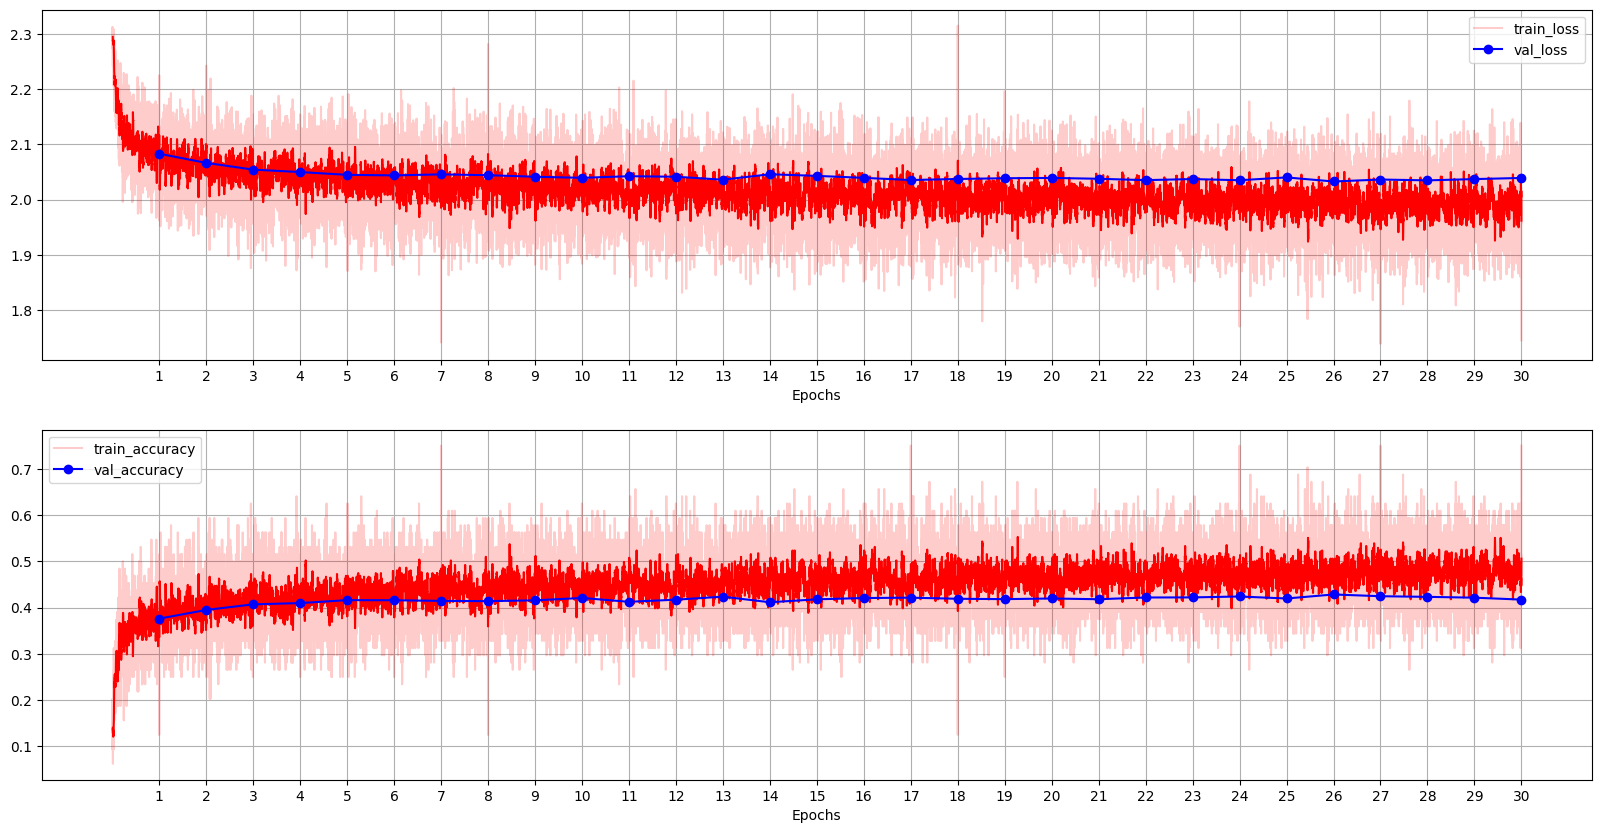

In [23]:
plot_metrics(*training_app.get_metrics(), w=8)

To sum up: **the linear model is not complex enough** to solve this classification problem, although it sets a baseline for the forthcoming models. Whatever complexity we add to the architecture, it must perform better than **42.84%** on the validation set.

### 3-layer Dense Network



Let's add some non-linearities now. The simplest way we can do that is by inserting a single **hidden layer**, with a non-linear activation function, between the input and the output layer. By doing this, the output layer is again a linear classifier, but now the inputs of the classifier are non-linear functions $\Phi(x)$ of the original inputs $x$, the so-called **feature functions**. In other words, the hidden layers in the neural network are responsable for extracting (learning) the optimal features or **representation**, which is then passed through an ordinary classifier!

<img src="./images_notebook/fc.jpeg" width="300">

With this extra level of complexity in the model, we can study again what happens when we train it on a very small dataset. Now, after 100 epochs, the model gets closer to overfitting by reaching 94.01% of accuracy on the small set, but only 33.31% on the validation set.

When training on the bigger set, after 30 epochs we get 62.92% for the training set and **50.85%** for validation, which is our new baseline.

In [ ]:
app_parameters = {'num_workers': 2,
                  'val_freq': 1,
                  'save_path': cwd + '/saved_models/fc',
                  'seed': 42}

hyperparameters = {'batch_size': 64,
                   'epochs': 30,
                   'model_parameters': {},
                   'optimizer_parameters': {'lr': 0.01, 'momentum': 0.9}}

design = {'model': Dense, 'criterion': nn.CrossEntropyLoss, 'optimizer': optim.SGD}

transformation = {'train': trans_32cifar, 'val': trans_32cifar}

training_app = CIFARTrainingApp(data_train,
                                data_val,
                                app_parameters,
                                hyperparameters,
                                transformation,
                                design)

print(f'\nModel: {training_app.model}')
n_parameters = np.sum([p.numel() for p in training_app.model.parameters()])
print(f'\nNumber of parameters: {n_parameters}\n')

print(f'\nCriterion: {training_app.criterion}')
print(f'\nOptimizer: {training_app.optimizer}')

Using cuda device
Random seed set as 42

Model: Dense(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

Number of parameters: 3157002


Criterion: CrossEntropyLoss()

Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


In [ ]:
training_app.main(validate_bool=True, save_bool=True)
metrics_train_df, metrics_val_df = training_app.get_metrics_df()

Loading data...

Start training with 704/79 batches (trn/val) of size 64 for 30 epochs



Epoch 1/30: 100%|██████████| 704/704 [00:14<00:00, 49.80it/s, Loss = 2.021, Acc = 37.50%]

Val Loss: 2.043 Val Acc: 41.14% (Best)



Epoch 2/30: 100%|██████████| 704/704 [00:16<00:00, 41.59it/s, Loss = 2.043, Acc = 37.50%]

Val Loss: 2.012 Val Acc: 44.40% (Best)



Epoch 3/30: 100%|██████████| 704/704 [00:17<00:00, 39.32it/s, Loss = 2.094, Acc = 37.50%]

Val Loss: 2.006 Val Acc: 45.15% (Best)



Epoch 4/30: 100%|██████████| 704/704 [00:16<00:00, 43.89it/s, Loss = 1.778, Acc = 62.50%]

Val Loss: 1.992 Val Acc: 46.36% (Best)



Epoch 5/30: 100%|██████████| 704/704 [00:16<00:00, 42.93it/s, Loss = 1.908, Acc = 50.00%]

Val Loss: 1.981 Val Acc: 47.49% (Best)



Epoch 6/30: 100%|██████████| 704/704 [00:13<00:00, 51.55it/s, Loss = 1.887, Acc = 62.50%]

Val Loss: 1.984 Val Acc: 47.13%



Epoch 7/30: 100%|██████████| 704/704 [00:13<00:00, 51.74it/s, Loss = 1.926, Acc = 37.50%]

Val Loss: 1.977 Val Acc: 47.98% (Best)



Epoch 8/30: 100%|██████████| 704/704 [00:13<00:00, 53.03it/s, Loss = 1.709, Acc = 75.00%]

Val Loss: 1.975 Val Acc: 47.96%



Epoch 9/30: 100%|██████████| 704/704 [00:13<00:00, 52.59it/s, Loss = 2.197, Acc = 25.00%]

Val Loss: 1.986 Val Acc: 46.97%



Epoch 10/30: 100%|██████████| 704/704 [00:14<00:00, 49.62it/s, Loss = 1.922, Acc = 50.00%]

Val Loss: 1.974 Val Acc: 48.52% (Best)



Epoch 11/30: 100%|██████████| 704/704 [00:14<00:00, 48.75it/s, Loss = 2.264, Acc = 12.50%]

Val Loss: 1.962 Val Acc: 49.49% (Best)



Epoch 12/30: 100%|██████████| 704/704 [00:14<00:00, 49.95it/s, Loss = 1.961, Acc = 50.00%]

Val Loss: 1.968 Val Acc: 48.97%



Epoch 13/30: 100%|██████████| 704/704 [00:13<00:00, 54.06it/s, Loss = 1.934, Acc = 50.00%]

Val Loss: 1.969 Val Acc: 48.75%



Epoch 14/30: 100%|██████████| 704/704 [00:13<00:00, 53.75it/s, Loss = 1.865, Acc = 62.50%]

Val Loss: 1.975 Val Acc: 48.40%



Epoch 15/30: 100%|██████████| 704/704 [00:13<00:00, 51.72it/s, Loss = 1.929, Acc = 62.50%]

Val Loss: 1.969 Val Acc: 48.66%



Epoch 16/30: 100%|██████████| 704/704 [00:14<00:00, 49.29it/s, Loss = 1.962, Acc = 50.00%]



Val Loss: 1.975 Val Acc: 48.22%



Epoch 17/30: 100%|██████████| 704/704 [00:14<00:00, 49.20it/s, Loss = 1.693, Acc = 75.00%]

Val Loss: 1.967 Val Acc: 49.15%



Epoch 18/30: 100%|██████████| 704/704 [00:13<00:00, 51.34it/s, Loss = 1.740, Acc = 75.00%]

Val Loss: 1.970 Val Acc: 48.71%



Epoch 19/30: 100%|██████████| 704/704 [00:13<00:00, 53.41it/s, Loss = 2.067, Acc = 37.50%]

Val Loss: 1.960 Val Acc: 49.66% (Best)



Epoch 20/30: 100%|██████████| 704/704 [00:13<00:00, 53.58it/s, Loss = 1.469, Acc = 100.00%]

Val Loss: 1.951 Val Acc: 50.83% (Best)



Epoch 21/30: 100%|██████████| 704/704 [00:13<00:00, 51.60it/s, Loss = 1.836, Acc = 62.50%]

Val Loss: 1.967 Val Acc: 49.01%



Epoch 22/30: 100%|██████████| 704/704 [00:14<00:00, 49.32it/s, Loss = 1.724, Acc = 75.00%]

Val Loss: 1.951 Val Acc: 50.85% (Best)



Epoch 23/30: 100%|██████████| 704/704 [00:14<00:00, 48.66it/s, Loss = 1.836, Acc = 62.50%]

Val Loss: 1.957 Val Acc: 50.24%



Epoch 24/30: 100%|██████████| 704/704 [00:13<00:00, 50.30it/s, Loss = 1.581, Acc = 87.50%]

Val Loss: 1.952 Val Acc: 50.83%



Epoch 25/30: 100%|██████████| 704/704 [00:13<00:00, 52.67it/s, Loss = 1.836, Acc = 62.50%]

Val Loss: 1.950 Val Acc: 50.79%



Epoch 26/30: 100%|██████████| 704/704 [00:13<00:00, 52.79it/s, Loss = 1.713, Acc = 75.00%]

Val Loss: 1.954 Val Acc: 50.53%



Epoch 27/30: 100%|██████████| 704/704 [00:14<00:00, 50.26it/s, Loss = 1.677, Acc = 75.00%]

Val Loss: 1.953 Val Acc: 50.53%



Epoch 28/30: 100%|██████████| 704/704 [00:21<00:00, 33.17it/s, Loss = 2.080, Acc = 37.50%]

Val Loss: 1.952 Val Acc: 50.61%



Epoch 29/30: 100%|██████████| 704/704 [00:21<00:00, 32.72it/s, Loss = 1.836, Acc = 62.50%]

Val Loss: 1.952 Val Acc: 50.61%



Epoch 30/30: 100%|██████████| 704/704 [00:16<00:00, 43.37it/s, Loss = 1.463, Acc = 100.00%]



Val Loss: 1.962 Val Acc: 49.58%

Train Loss: 1.831 Train Acc: 62.92%
Best accuracy: 50.85%


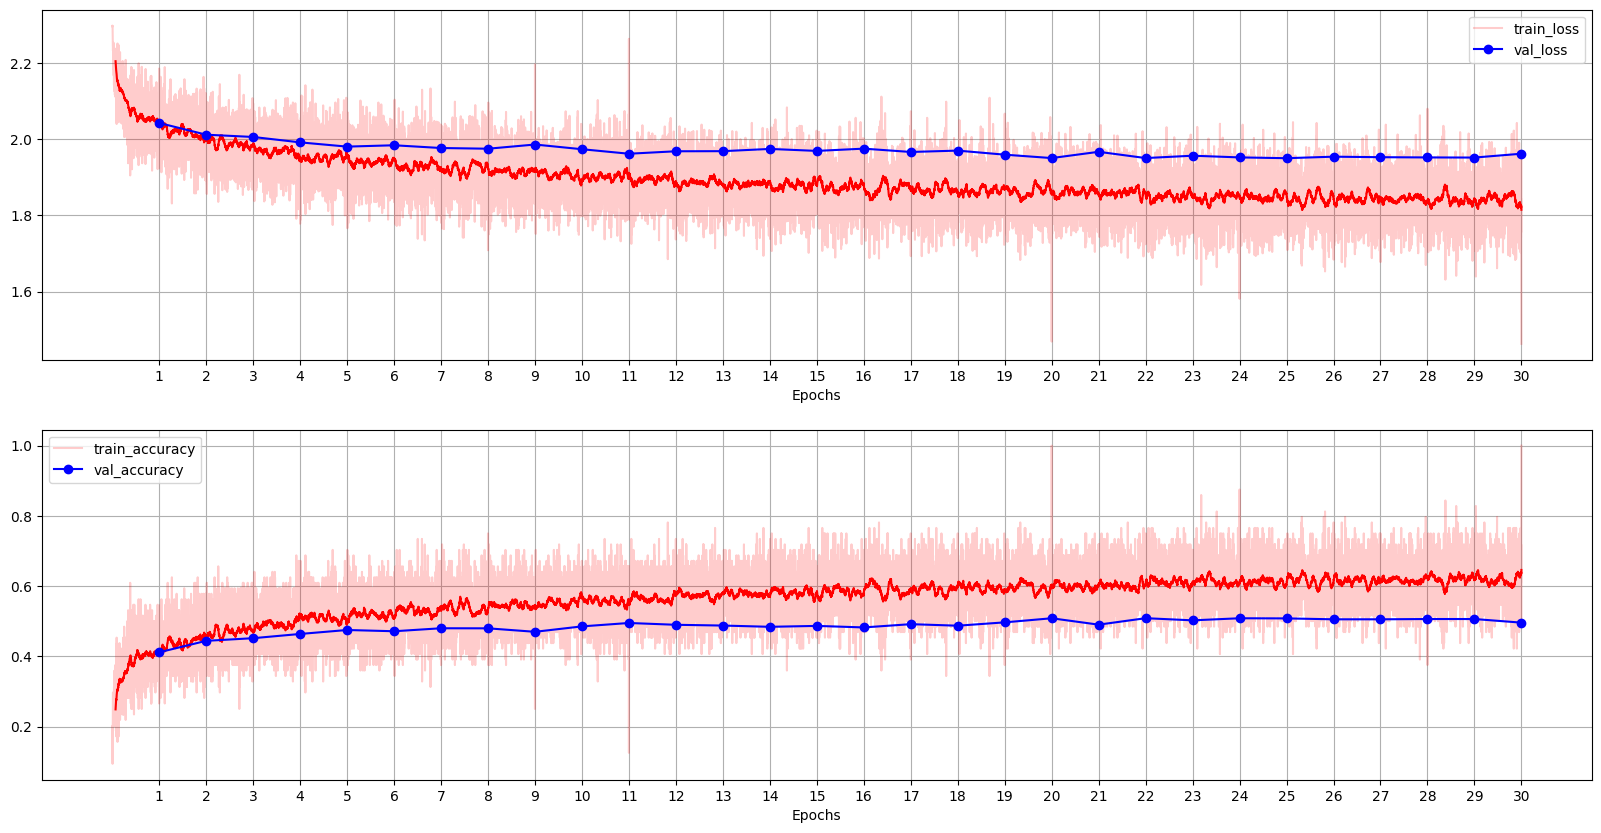

In [ ]:
plot_metrics(metrics_train_df, metrics_val_df, w=50)

Due to the high number of parameters, more than 3 millons, probably with more epochs we could get better accuracies for both sets, perhaps even get close to overfitting the training set. Moreover, we could go even further and add more hidden layers, making the network deeper. However, for computer vision tasks, in which inputs are images, fully-connected networks are very limited. They do not scale well to such huge number of features: each fully-connected layer adds a big number of parameter, which quickly makes the system untractable and prone to overfitting. Even with regularization techniques, these networks would take an unnecesary amount of time to converge, if at all.

We will now introduce other network architectures that use their resources in a smarter way and see how, with less parameters, we can achieve much better performance than **50.85%**.

## Convolutional Neural Networks: Classical Networks

We will now get into the realm of **convolutional neural networks (CNNs)**. These architectures are specifically designed to account for the inputs being images, namely, 3D objects representing (width, height, depth), where depth corresponds to the number of channels.

There are numerous architectures, but all of them are built from the combination of at least the following type of layers: **convolutional (conv) layers**, **pooling layers**, and **fully-connected layers**.

The conv layers compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. The pooling layer performs a downsampling operation over the spatial directions. The fully-connected layers sit at the end of the CNN. They take the features extracted from the conv + poolling layers and outputs the scores for classification.

In this first part, we study the so-called **classical CNNs**, corresponding to the first and most iconic
architectures that set the fundations for modern approaches. Their implementations, which we built from scratch, are stored in the `models.py` file.

### LeNet-5

[LeNet-5](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) was one of the first succesfull applications of CNNs architectures, created by **Yann LeCun et. al. in 1998**. For nowadays standards it is a very simple, and shallow network with just 2 conv layers and 3 fully-connected ones, and only $60K$ parameters!

<img src="./images_notebook/lenet5.jpeg" width="600">

We buildt the network from scratch and test it on the small dataset first. After 200 epochs we obtained 65.29% for the small set and 27.91% for the validation set. This tells us that the model is not complex enough even to overfit the small dataset.

However, the model generalized better than the fully-connected architectures, as it can be seen by training it on the bigger set. We first trained the raw model for 25 epochs and a learning rate of $lr = 0.01$, but the model presented **numerical instabilities** (sudden drop of training and validation accuracy). By lowering the learning rate (a common technique when encountering numerical instabilities) to $lr=0.002$ and training for 60 epochs we found a huge increase in performance of 73.81% for the training set and **62.14%** for the validation set! Moreover, it is likely that with more training and a further fine tuning of hyperparameters, LeNet-5 can achieve even a better accuracy.

Regularization, on the other hand, seems not to be needed because:

1. The model is not that complex for the amount of data we have
2. Training and validation accuracies are quiet close to each other, giving no signs of overfitting.

In [ ]:
app_parameters = {'num_workers': 2,
                  'val_freq': 1,
                  'save_path': cwd + '/saved_models/lenet5',
                  'seed': 42}

hyperparameters = {'batch_size': 64,
                   'epochs': 2,
                   'model_parameters': {},
                   'optimizer_parameters': {'lr': 0.002, 'momentum': 0.9, 'weight_decay': 0.0}}

design = {'model': LeNet5, 'criterion': nn.CrossEntropyLoss, 'optimizer': optim.SGD}
transformation = {'train': trans_32cifar, 'val': trans_32cifar}

training_app = CIFARTrainingApp(data_train,
                                data_val,
                                app_parameters,
                                hyperparameters,
                                transformation,
                                design)

print(f'\nModel: {training_app.model}')
n_parameters = np.sum([p.numel() for p in training_app.model.parameters()])
print(f'\nNumber of parameters: {n_parameters}\n')

print(f'\nCriterion: {training_app.criterion}')
print(f'\nOptimizer: {training_app.optimizer}')

Using cuda device
Random seed set as 42

Model: LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Number of parameters: 62006


Criterion: CrossEntropyLoss()

Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0
)


In [ ]:
training_app.main(validate_bool=True, save_bool=True)
metrics_train_df, metrics_val_df = training_app.get_metrics()

Loading data...

Start training with 704/79 batches (trn/val) of size 64 for 2 epochs



Epoch 1/2: 100%|██████████| 704/704 [00:12<00:00, 58.32it/s, Loss = 2.293, Acc = 25.00%]

Val Loss: 2.299 Val Acc: 14.20% (Best) (0:00:13)



Epoch 2/2: 100%|██████████| 704/704 [00:12<00:00, 57.22it/s, Loss = 2.225, Acc = 12.50%]



Val Loss: 2.247 Val Acc: 20.31% (Best) (0:00:26)

Train Loss: 2.247 Train Acc: 20.19%
Best accuracy: 20.31%


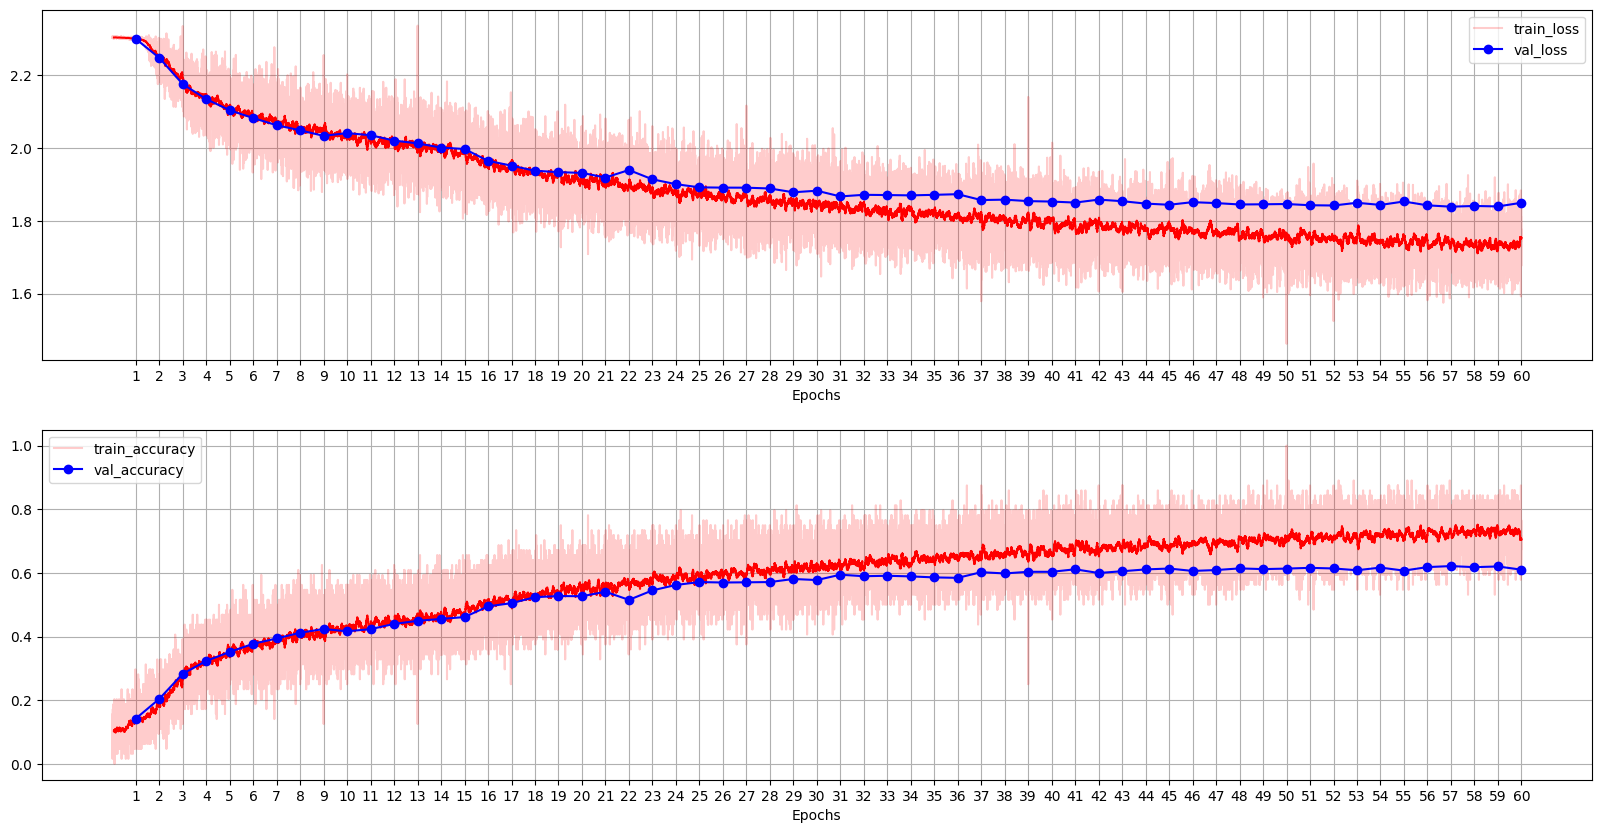

In [ ]:
plot_metrics(metrics_train_df, metrics_val_df, w=50)

To sum up, with just $60K$ parameters, being just a fraction of the $3 M$ from the previous 3-layer fully-connected network, LeNet-5 outperforms our previous baseline for more than 10%! Let's see how we can make it even better than **62.14%** with a more complex architecture.

### AlexNet

[AlexNet](https://papers.nips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf), created by **Alex Krizhevsky, Ilya Sutskever and Geoff Hinton in 2012**, was the first architectured that popularized CNNs in CV by wining the **ImageNet Large Scale Visual Recognition Challenge** in 2012 by more than 10% compared to the runner up. It has a very similar architecture to LeNet-5, but it is deeper, bigger, and features conv layers stacked on top of each other (instead of always having pool layers in the middle).

<img src="./images_notebook/alexnet.webp" width="600">

The original architecture has $62 M$ parameters. Replacing the original 1000 output neurons (ImageNet) for 10 (CIFAR-10) it reduces to $58 M$. This is a 1000X increase in complexity compared to LeNet-5! Interestingly, most of those parameters come from the last 3 fully-connected layers. If we replace them for just a single classifier, taking the output of the conv layers and returning 10 probabilities, one for each class, the number of parameters reduce to $3.8 M$!

We now train different versions of AlexNet and compare them against each other. All of these architectures take a 3-channel image, whose size is at least (224, 224). This is because the original AlexNet was buildt to classify images from the [ImageNet dataset](https://www.image-net.org/). Since CIFAR-10 contains images of size (32, 32), we need to add a resize transformation in our pre-processing step. Remember we already took care of this by defining the transformation `trans_227cifar` above.

We trained on the original AlexNet (replacing 1000 to 10 outputs) and we arrived at the following results and conclusions:

* When training at $lr=0.01$, the model suffers from numerical instabilities, reaching at most 52% of accuracy for the validation set and then dropping drastically before 10 epochs. From here we have two inmediate options: lowering the learning rate, or using more sophisticated stabilization techniques.
* Lowering the learning rate to $lr=0.002$, we managed to train the model for 50 epochs reaching a new record of **73.97%** accuracy for the validation set and 93.70% for the training set. However, the training process goes really slow, taking almost 2 hours in a google collab's GPU.
* If we now instead keep $lr=0.01$ but also add `BatcNorm` layers before each non-linearity (to standarize the activations in a differential way) and initialize the parameters using [He weight initialization](https://arxiv.org/abs/1502.01852), we achieve **81.11%** accuracy for the validation set with just 15 epochs and taking less than 35 minutes! This is a clear triumph of batch normalization! Additionally, the training set accuracy reaches more than 97%, suggesting that we can do better by including regularization into the game.
* By adding regularization to the previous architecture in the form of `dropout` layers with $p=0.5$ and L2 norm with weight decay rate of $0.0001$ we achieve **84.32%** after 50 epochs. For the training set we obtain 97.85% which suggests that we can still do better by adding even more regularization. We will not pursue such fine-tunning for this model.

Just out of curiousity, we also checked our own version of AlexNet where all fully-connected layers are replaced by a single classifier. Using batch normalization, He weigth initialization and L2 regularization we achieved **82.69%** validation accuracy after 50 epochs. Moreover, training accuracy reached 97.69%, which suggests that this simpler model (just 10% of the parameters in original AlexNet) can get even better performance if we add more regularization!

In [ ]:
app_parameters = {'num_workers': 2,
                  'val_freq': 1,
                  'save_path': cwd + '/saved_models/alexnet_1fc_norm_lr0005',
                  'seed': 42}

hyperparameters = {'batch_size': 64,
                   'epochs': 50,
                   'model_parameters': {},
                   'optimizer_parameters': {'lr': 0.005, 'momentum': 0.9, 'weight_decay': 0.0}}

design = {'model': AlexNet1Fc, 'criterion': nn.CrossEntropyLoss, 'optimizer': optim.SGD}

transformation = {'train': trans_227cifar, 'val': trans_227cifar}

training_app = CIFARTrainingApp(data_train,
                                data_val,
                                app_parameters,
                                hyperparameters,
                                transformation,
                                design)

print(f'\nModel: {training_app.model}')
n_parameters = np.sum([p.numel() for p in training_app.model.parameters()])
print(f'\nNumber of parameters: {n_parameters}\n')

print(f'\nCriterion: {training_app.criterion}')
print(f'\nOptimizer: {training_app.optimizer}')

Using cuda device
Random seed set as 42

Model: AlexNet1Fc(
  (conv_layers): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), bias=False)
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1

In [ ]:
training_app.main(validate_bool=True, save_bool=True)
metrics_train_df, metrics_val_df = get_metrics_df(training_app.metrics_train, training_app.metrics_val)

Loading data...

Start training with 704/79 batches (trn/val) of size 64 for 50 epochs



Epoch 1/50: 100%|██████████| 704/704 [01:47<00:00,  6.52it/s, Loss = 1.981, Acc = 50.00%]

Val Loss: 2.077 Val Acc: 38.23% (Best) (0:01:58)



Epoch 2/50: 100%|██████████| 704/704 [01:45<00:00,  6.64it/s, Loss = 1.947, Acc = 50.00%]

Val Loss: 2.041 Val Acc: 41.57% (Best) (0:03:56)



Epoch 3/50: 100%|██████████| 704/704 [01:47<00:00,  6.53it/s, Loss = 2.073, Acc = 37.50%]

Val Loss: 1.987 Val Acc: 47.07% (Best) (0:05:54)



Epoch 4/50: 100%|██████████| 704/704 [01:48<00:00,  6.51it/s, Loss = 1.967, Acc = 50.00%]

Val Loss: 1.974 Val Acc: 48.30% (Best) (0:07:53)



Epoch 5/50: 100%|██████████| 704/704 [01:45<00:00,  6.67it/s, Loss = 1.973, Acc = 50.00%]

Val Loss: 1.964 Val Acc: 49.55% (Best) (0:09:50)



Epoch 6/50: 100%|██████████| 704/704 [01:47<00:00,  6.52it/s, Loss = 1.712, Acc = 75.00%]

Val Loss: 1.950 Val Acc: 50.91% (Best) (0:11:48)



Epoch 7/50: 100%|██████████| 704/704 [01:47<00:00,  6.54it/s, Loss = 2.078, Acc = 37.50%]

Val Loss: 1.939 Val Acc: 52.04% (Best) (0:13:47)



Epoch 8/50: 100%|██████████| 704/704 [01:46<00:00,  6.61it/s, Loss = 1.701, Acc = 75.00%]

Val Loss: 1.931 Val Acc: 52.65% (Best) (0:15:44)



Epoch 9/50: 100%|██████████| 704/704 [01:48<00:00,  6.47it/s, Loss = 1.836, Acc = 62.50%]

Val Loss: 1.927 Val Acc: 53.16% (Best) (0:17:44)



Epoch 10/50: 100%|██████████| 704/704 [01:46<00:00,  6.61it/s, Loss = 2.319, Acc = 12.50%]

Val Loss: 1.913 Val Acc: 54.53% (Best) (0:19:42)



Epoch 11/50: 100%|██████████| 704/704 [01:49<00:00,  6.45it/s, Loss = 1.834, Acc = 62.50%]

Val Loss: 1.913 Val Acc: 54.83% (Best) (0:21:42)



Epoch 12/50: 100%|██████████| 704/704 [01:47<00:00,  6.56it/s, Loss = 1.759, Acc = 62.50%]

Val Loss: 1.896 Val Acc: 56.33% (Best) (0:23:41)



Epoch 13/50: 100%|██████████| 704/704 [01:48<00:00,  6.49it/s, Loss = 1.829, Acc = 62.50%]



Val Loss: 1.918 Val Acc: 54.19% (0:25:39)



Epoch 14/50: 100%|██████████| 704/704 [01:48<00:00,  6.49it/s, Loss = 1.843, Acc = 62.50%]

Val Loss: 1.901 Val Acc: 55.68% (0:27:39)



Epoch 15/50: 100%|██████████| 704/704 [01:46<00:00,  6.62it/s, Loss = 1.941, Acc = 50.00%]

Val Loss: 1.891 Val Acc: 56.61% (Best) (0:29:36)



Epoch 16/50: 100%|██████████| 704/704 [01:48<00:00,  6.49it/s, Loss = 1.864, Acc = 62.50%]

Val Loss: 1.910 Val Acc: 54.92% (0:31:35)



Epoch 17/50: 100%|██████████| 704/704 [01:47<00:00,  6.55it/s, Loss = 1.689, Acc = 75.00%]

Val Loss: 1.884 Val Acc: 57.50% (Best) (0:33:34)



Epoch 18/50: 100%|██████████| 704/704 [01:48<00:00,  6.50it/s, Loss = 1.837, Acc = 62.50%]

Val Loss: 1.891 Val Acc: 56.82% (0:35:32)



Epoch 19/50: 100%|██████████| 704/704 [01:48<00:00,  6.48it/s, Loss = 1.826, Acc = 62.50%]

Val Loss: 1.875 Val Acc: 58.21% (Best) (0:37:32)



Epoch 20/50: 100%|██████████| 704/704 [01:46<00:00,  6.58it/s, Loss = 2.082, Acc = 37.50%]

Val Loss: 1.882 Val Acc: 57.73% (0:39:31)



Epoch 21/50: 100%|██████████| 704/704 [01:48<00:00,  6.48it/s, Loss = 1.833, Acc = 62.50%]

Val Loss: 1.881 Val Acc: 57.69% (0:41:30)



Epoch 22/50: 100%|██████████| 704/704 [01:47<00:00,  6.57it/s, Loss = 1.802, Acc = 62.50%]

Val Loss: 1.862 Val Acc: 59.75% (Best) (0:43:29)



Epoch 23/50: 100%|██████████| 704/704 [01:48<00:00,  6.49it/s, Loss = 1.477, Acc = 100.00%]

Val Loss: 1.831 Val Acc: 62.84% (Best) (0:45:27)



Epoch 24/50: 100%|██████████| 704/704 [01:48<00:00,  6.51it/s, Loss = 1.619, Acc = 87.50%]

Val Loss: 1.791 Val Acc: 66.73% (Best) (0:47:26)



Epoch 25/50: 100%|██████████| 704/704 [01:47<00:00,  6.53it/s, Loss = 1.474, Acc = 100.00%]

Val Loss: 1.749 Val Acc: 71.06% (Best) (0:49:25)



Epoch 26/50: 100%|██████████| 704/704 [01:49<00:00,  6.45it/s, Loss = 1.750, Acc = 75.00%]

Val Loss: 1.741 Val Acc: 71.78% (Best) (0:51:26)



Epoch 27/50: 100%|██████████| 704/704 [01:47<00:00,  6.55it/s, Loss = 1.899, Acc = 50.00%]

Val Loss: 1.773 Val Acc: 68.69% (0:53:25)



Epoch 28/50: 100%|██████████| 704/704 [01:49<00:00,  6.43it/s, Loss = 1.589, Acc = 87.50%]

Val Loss: 1.738 Val Acc: 72.27% (Best) (0:55:25)



Epoch 29/50: 100%|██████████| 704/704 [01:48<00:00,  6.50it/s, Loss = 1.605, Acc = 75.00%]

Val Loss: 1.723 Val Acc: 73.93% (Best) (0:57:24)



Epoch 30/50: 100%|██████████| 704/704 [01:49<00:00,  6.42it/s, Loss = 1.716, Acc = 75.00%]

Val Loss: 1.729 Val Acc: 73.18% (0:59:24)



Epoch 31/50: 100%|██████████| 704/704 [01:49<00:00,  6.40it/s, Loss = 1.588, Acc = 87.50%]

Val Loss: 1.686 Val Acc: 77.55% (Best) (1:01:25)



Epoch 32/50: 100%|██████████| 704/704 [01:49<00:00,  6.45it/s, Loss = 1.676, Acc = 75.00%]

Val Loss: 1.671 Val Acc: 78.82% (Best) (1:03:24)



Epoch 33/50: 100%|██████████| 704/704 [01:49<00:00,  6.45it/s, Loss = 1.764, Acc = 75.00%]

Val Loss: 1.676 Val Acc: 78.62% (1:05:25)



Epoch 34/50: 100%|██████████| 704/704 [01:47<00:00,  6.53it/s, Loss = 1.647, Acc = 75.00%]



Val Loss: 1.665 Val Acc: 79.65% (Best) (1:07:23)



Epoch 35/50: 100%|██████████| 704/704 [01:49<00:00,  6.46it/s, Loss = 1.711, Acc = 75.00%]

Val Loss: 1.680 Val Acc: 78.16% (1:09:24)



Epoch 36/50: 100%|██████████| 704/704 [01:47<00:00,  6.55it/s, Loss = 1.484, Acc = 100.00%]

Val Loss: 1.676 Val Acc: 78.82% (1:11:23)



Epoch 37/50: 100%|██████████| 704/704 [01:49<00:00,  6.42it/s, Loss = 1.643, Acc = 87.50%]

Val Loss: 1.665 Val Acc: 79.63% (1:13:23)



Epoch 38/50: 100%|██████████| 704/704 [01:48<00:00,  6.48it/s, Loss = 1.461, Acc = 100.00%]

Val Loss: 1.647 Val Acc: 81.74% (Best) (1:15:23)



Epoch 39/50: 100%|██████████| 704/704 [01:50<00:00,  6.38it/s, Loss = 1.463, Acc = 100.00%]

Val Loss: 1.654 Val Acc: 80.89% (1:17:24)



Epoch 40/50: 100%|██████████| 704/704 [01:48<00:00,  6.49it/s, Loss = 1.461, Acc = 100.00%]

Val Loss: 1.647 Val Acc: 81.53% (1:19:24)



Epoch 41/50: 100%|██████████| 704/704 [01:49<00:00,  6.46it/s, Loss = 1.462, Acc = 100.00%]



Val Loss: 1.658 Val Acc: 80.36% (1:21:22)



Epoch 42/50: 100%|██████████| 704/704 [01:49<00:00,  6.44it/s, Loss = 1.475, Acc = 100.00%]

Val Loss: 1.654 Val Acc: 81.07% (1:23:23)



Epoch 43/50: 100%|██████████| 704/704 [01:47<00:00,  6.53it/s, Loss = 1.580, Acc = 87.50%]

Val Loss: 1.660 Val Acc: 80.18% (1:25:21)



Epoch 44/50: 100%|██████████| 704/704 [01:49<00:00,  6.44it/s, Loss = 1.464, Acc = 100.00%]

Val Loss: 1.650 Val Acc: 81.25% (1:27:22)



Epoch 45/50: 100%|██████████| 704/704 [01:48<00:00,  6.49it/s, Loss = 1.461, Acc = 100.00%]

Val Loss: 1.653 Val Acc: 81.09% (1:29:22)



Epoch 46/50: 100%|██████████| 704/704 [01:50<00:00,  6.40it/s, Loss = 1.464, Acc = 100.00%]

Val Loss: 1.639 Val Acc: 82.22% (Best) (1:31:22)



Epoch 47/50: 100%|██████████| 704/704 [01:49<00:00,  6.46it/s, Loss = 1.462, Acc = 100.00%]

Val Loss: 1.642 Val Acc: 82.28% (Best) (1:33:23)



Epoch 48/50: 100%|██████████| 704/704 [01:49<00:00,  6.43it/s, Loss = 1.463, Acc = 100.00%]

Val Loss: 1.643 Val Acc: 81.78% (1:35:21)



Epoch 49/50: 100%|██████████| 704/704 [01:49<00:00,  6.42it/s, Loss = 1.586, Acc = 87.50%]

Val Loss: 1.647 Val Acc: 81.37% (1:37:23)



Epoch 50/50: 100%|██████████| 704/704 [01:50<00:00,  6.40it/s, Loss = 1.502, Acc = 100.00%]

Val Loss: 1.638 Val Acc: 82.69% (Best) (1:39:22)

Train Loss: 1.485 Train Acc: 97.69%
Best accuracy: 82.69%


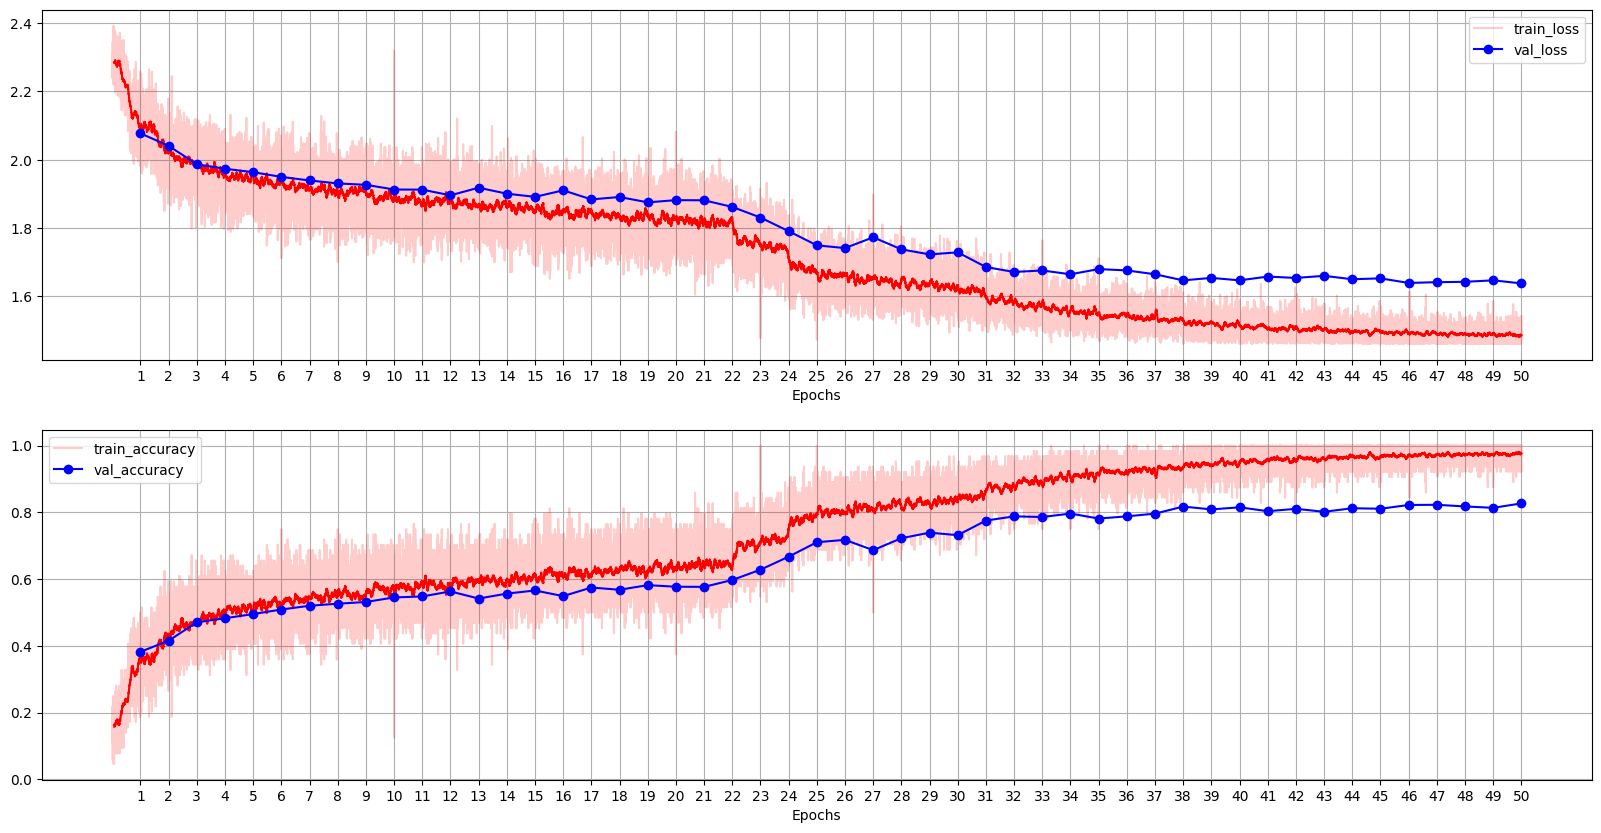

In [ ]:
plot_metrics(metrics_train_df, metrics_val_df, w=50)

All in all, AlexNet clearly outperforms the fully-connected and LeNet-5 architectures by a big amount, setting the new benchmark of **84.32%**. To achieve such accuracy, however, it was neccessary to implement some regularization and stabilization techniques. These are usefull methods when it comes to dealing with deeper networks, and therefore a common practice in modern models. We will see how its incorporation to the following deeper architectures is a must!

### VGG-16

[VGGNet](https://www.robots.ox.ac.uk/~vgg/research/very_deep/) was proposed by the **Visual Geometry Group at the University of Oxford in 2014**, it was one of the deeper networks at the time and its main contribution to computer vision was in showing that the depth of the network is a critical component for good performance. The network follows a uniform architecture, using a stack of convolutional layers with small receptive fields (3x3) and max-pooling layers. The use of 3x3 filters allows the network to learn more sophisticated features and reduces the number of parameters. The original VGGNet had configurations with 16 (VGG16) or 19 (VGG19) weight layers.

<img src="./images_notebook/vgg16.webp" width="600">

Being the last classical network we explore in the notebook, we also built it from scratch. We used VGG16, which includes 13 conv and 3 fully-connected layers. The network contains $134 M$ parameters, a huge number even for modern standards. Because of this, the training process is considerably expensive and we could not try many configurations. Using batch normalization, dropout and L2 regularization, we trained the model for 22 epochs (more than 4 hours) and we achieved 95.73% of accuracy on the training set and **84.65** for the validation set. This is just a small improvement compared to what we obtained with AlexNet, which contains less than half of the parameters! Presumably a better performance can be achieved after further training and fine-tunning.

In [ ]:
app_parameters = {'num_workers': 2,
                  'val_freq': 1,
                  'save_path': cwd + '/saved_models/vgg16',
                  'seed': 42}

hyperparameters = {'batch_size': 64,
                   'epochs': 10,
                   'model_parameters': {'p': 0.5},
                   'optimizer_parameters': {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.002}}

design = {'model': VGG16, 'criterion': nn.CrossEntropyLoss, 'optimizer': optim.SGD}

transformation = {'train': trans_224cifar, 'val': trans_224cifar}

training_app = CIFARTrainingApp(data_train,
                                data_val,
                                app_parameters,
                                hyperparameters,
                                transformation,
                                design)

print(f'\nModel: {training_app.model}')
n_parameters = np.sum([p.numel() for p in training_app.model.parameters()])
print(f'\nNumber of parameters: {n_parameters}\n')

print(f'\nCriterion: {training_app.criterion}')
print(f'\nOptimizer: {training_app.optimizer}')

Using cuda device
Random seed set as 42

Model: VGG16(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, d

In [ ]:
training_app.main(validate_bool=True, save_bool=True)
metrics_train_df, metrics_val_df = training_app.get_metrics()

Loading data...

Start training with 704/79 batches (trn/val) of size 64 for 10 epochs



Epoch 1/10: 100%|██████████| 704/704 [11:47<00:00,  1.00s/it, Loss = 1.929, Acc = 62.50%]

Val Loss: 1.652 Val Acc: 82.61% (Best) (0:12:14)



Epoch 2/10: 100%|██████████| 704/704 [11:52<00:00,  1.01s/it, Loss = 1.668, Acc = 75.00%]

Val Loss: 1.645 Val Acc: 83.58% (Best) (0:24:42)



Epoch 3/10: 100%|██████████| 704/704 [11:47<00:00,  1.00s/it, Loss = 1.830, Acc = 62.50%]

Val Loss: 1.654 Val Acc: 82.81% (0:37:04)



Epoch 4/10: 100%|██████████| 704/704 [11:46<00:00,  1.00s/it, Loss = 1.787, Acc = 75.00%]

Val Loss: 1.651 Val Acc: 83.13% (0:49:23)



Epoch 5/10: 100%|██████████| 704/704 [11:47<00:00,  1.01s/it, Loss = 1.662, Acc = 87.50%]

Val Loss: 1.652 Val Acc: 82.93% (1:01:39)



Epoch 6/10: 100%|██████████| 704/704 [11:46<00:00,  1.00s/it, Loss = 1.608, Acc = 87.50%]

Val Loss: 1.657 Val Acc: 82.56% (1:13:58)



Epoch 7/10: 100%|██████████| 704/704 [11:48<00:00,  1.01s/it, Loss = 1.712, Acc = 75.00%]

Val Loss: 1.677 Val Acc: 80.85% (1:26:14)



Epoch 8/10: 100%|██████████| 704/704 [11:47<00:00,  1.01s/it, Loss = 1.532, Acc = 100.00%]

Val Loss: 1.638 Val Acc: 84.65% (Best) (1:38:30)



Epoch 9/10: 100%|██████████| 704/704 [11:48<00:00,  1.01s/it, Loss = 1.598, Acc = 87.50%]

Val Loss: 1.669 Val Acc: 81.41% (1:50:58)



Epoch 10/10: 100%|██████████| 704/704 [11:45<00:00,  1.00s/it, Loss = 1.752, Acc = 87.50%]

Val Loss: 1.662 Val Acc: 82.16% (2:03:11)

Train Loss: 1.528 Train Acc: 95.73%
Best accuracy: 84.65%


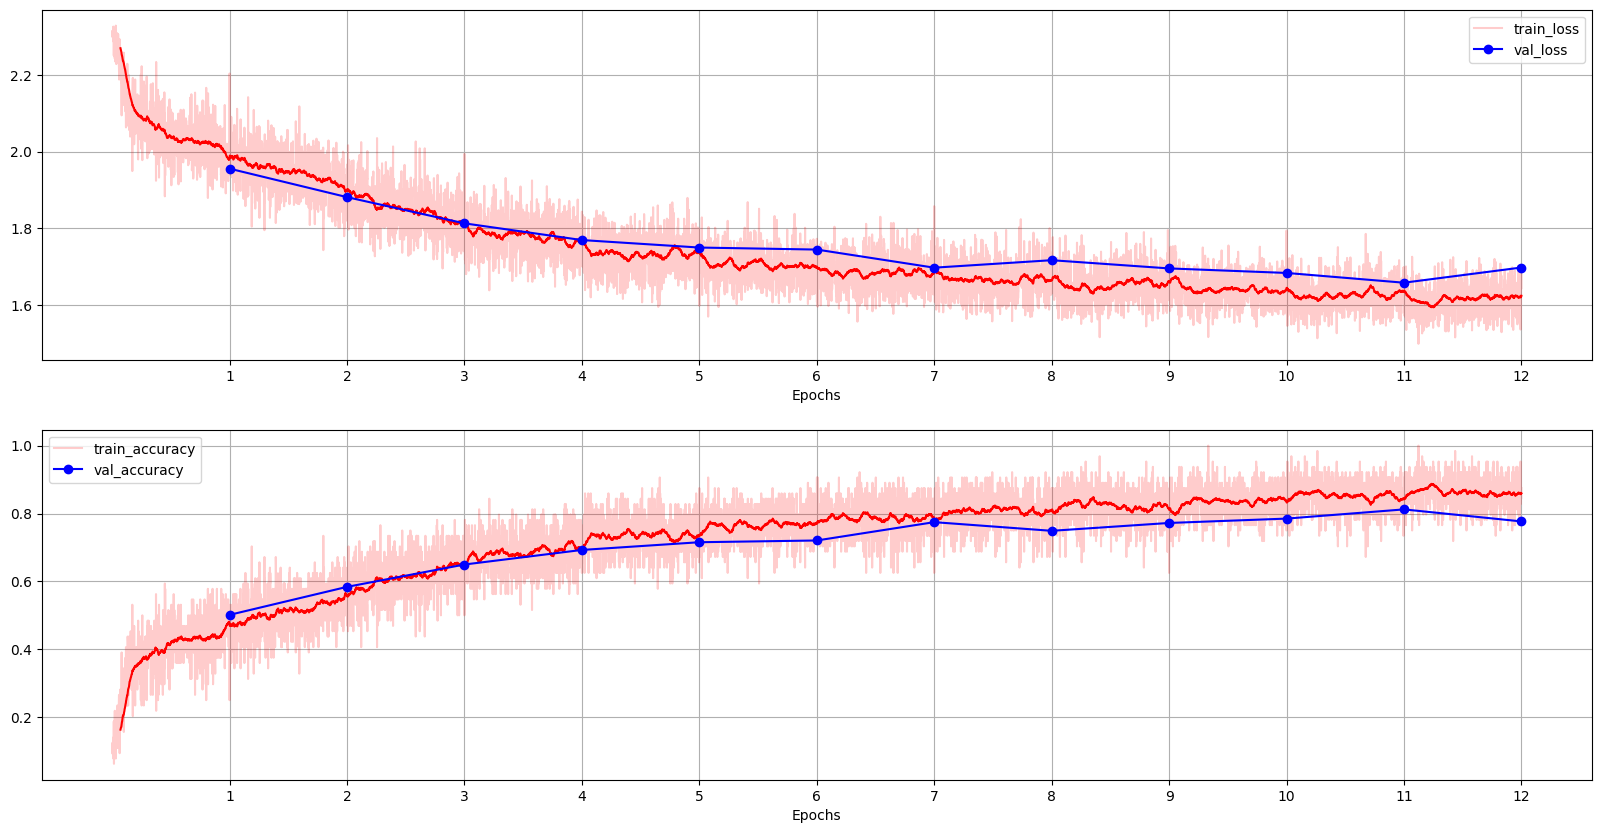

In [ ]:
plot_metrics(*training_app.get_metrics(), w=50)

## Convolutional Neural Networks: Modern Architectures

Now things become more interesting!

After analyzing some of the first and most iconic CNNs architectures in computer vision, we jump into more advanced models. To these days, these models are not only used as baselines but also seve as building blocks for more advanced architectures.

Compared to the classical networks, the following models are deeper, bigger, and more complex. As such, training them requires much more computational resources, and even with modern GPUs it can take several hours or days to achieve SOTA performance. Because of this, from now on we will make use of **transfer learning** by starting from **pre-trained models** and **fine-tuning** their parameters for our particular task. By this we mean that, instead of building the networks from scratch and initializing their parameters randomly, we will load publicly available implementations of the architectures together with specific parameters that were trained for us. To this end, we use [Pytorch's hub](https://pytorch.org/hub/), which contains several pre-trained models. For other networks it could be worth also exploring [Hugging Face](https://huggingface.co/models).

In our particular case, we will use models that were trained on ImageNet and so we have to replace the last (fully-connected) layer of each architecture for our own classifier, as well as fine-tune the resulting model to perform well in our CIFAR-10 dataset. Moreover, when using pre-trained models we need to be careful on using the same pre-processing transformations used on the original training data. This is handled by creating an instance of `CustomTransform` which resizes the images to $224 \times 244$, and standarizes the images using the mean and std values coming from the ImageNet training dataset. We already built such transformation, and saved it in `trans_224imagenet`.

### ResNet

[ResNet](https://arxiv.org/abs/1512.03385), short for Residual Network, is a deep neural network architecture that was introduced to address the challenges of training very deep neural networks. It was introduced by **Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun** at the 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR).

The key innovation in ResNet is the use of **residual blocks**. These blocks contain **"skip connections"** or **"shortcut connections"** that bypass one or more layers. The idea is to facilitate the flow of information from the input directly to the output, addressing the vanishing gradient problem associated with training deep networks. The network comes in different variants depending on the number of layers, including ResNet-18, ResNet-34, ResNet-50, ResNet-101, and ResNet-152.

<img src="./images_notebook/resnet50.png" width="600">

We will use the pretrained ResNet-50 model from [Pytorch vision models](https://pytorch.org/hub/pytorch_vision_resnet/) (the same model can also be obtained from [Hugging Face](https://huggingface.co/microsoft/resnet-50)) but we need to change the classifier layer to one that returns 10 outputs, as dictated by the CIFAR10 dataset. The latter needs to be trained from scratch using our dataset. We encode this hybrid pre-trained + custom model into the wrapper class `ResNet50Wrapper` which, as usual, must be a subclass of `nn.Module`.

Since in our case we we have a lot of data, we can make use of it to train not only the new classifier layer, but also update the parameters of the original ResNet-50. This fine-tuned model for sure will perform better than the one with the original ImageNet features!

We performed a small manual hyperparameter search by trying out different learning rates and weight-decay parameters. The best model was achieved with a learning rate of $lr=0.01$ and no regularization. After 20 epochs, it reached 99.77% accuracy for the training set and **96.38%** for the validation set.

In [ ]:
app_parameters = {'num_workers': 2,
                  'val_freq': 1,
                  'save_path': cwd + '/saved_models/resnet50_wd0002',
                  'seed': 42}

hyperparameters = {'batch_size': 64,
                   'epochs': 10,
                   'model_parameters': {},
                   'optimizer_parameters': {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0002}}

design = {'model': ResNet50Wrapper, 'criterion': nn.CrossEntropyLoss, 'optimizer': optim.SGD}

transformation = {'train': trans_224imagenet, 'val': trans_224imagenet}

training_app = CIFARTrainingApp(data_train,
                                data_val,
                                app_parameters,
                                hyperparameters,
                                transformation,
                                design)

print(f'\nModel: {training_app.model}')
n_parameters = np.sum([p.numel() for p in training_app.model.parameters()])
print(f'\nNumber of parameters: {n_parameters}\n')

print(f'\nCriterion: {training_app.criterion}')
print(f'\nOptimizer: {training_app.optimizer}')

Using cuda device
Random seed set as 42


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 145MB/s]



Model: ResNet50Wrapper(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

In [ ]:
training_app.load_state(cwd + '/saved_models/resnet50_noreg_2024-01-12_17.46.34.state')

In [ ]:
training_app.main(validate_bool=True, save_bool=True)
metrics_train_df, metrics_val_df = training_app.get_metrics()

Loading data...

Start training with 704/79 batches (trn/val) of size 64 for 10 epochs



Epoch 1/10: 100%|██████████| 704/704 [07:46<00:00,  1.51it/s, Loss = 1.463, Acc = 100.00%]

Val Loss: 1.506 Val Acc: 95.77% (Best) (0:08:03)



Epoch 2/10:  45%|████▍     | 315/704 [03:28<04:15,  1.52it/s, Loss = 1.461, Acc = 100.00%]

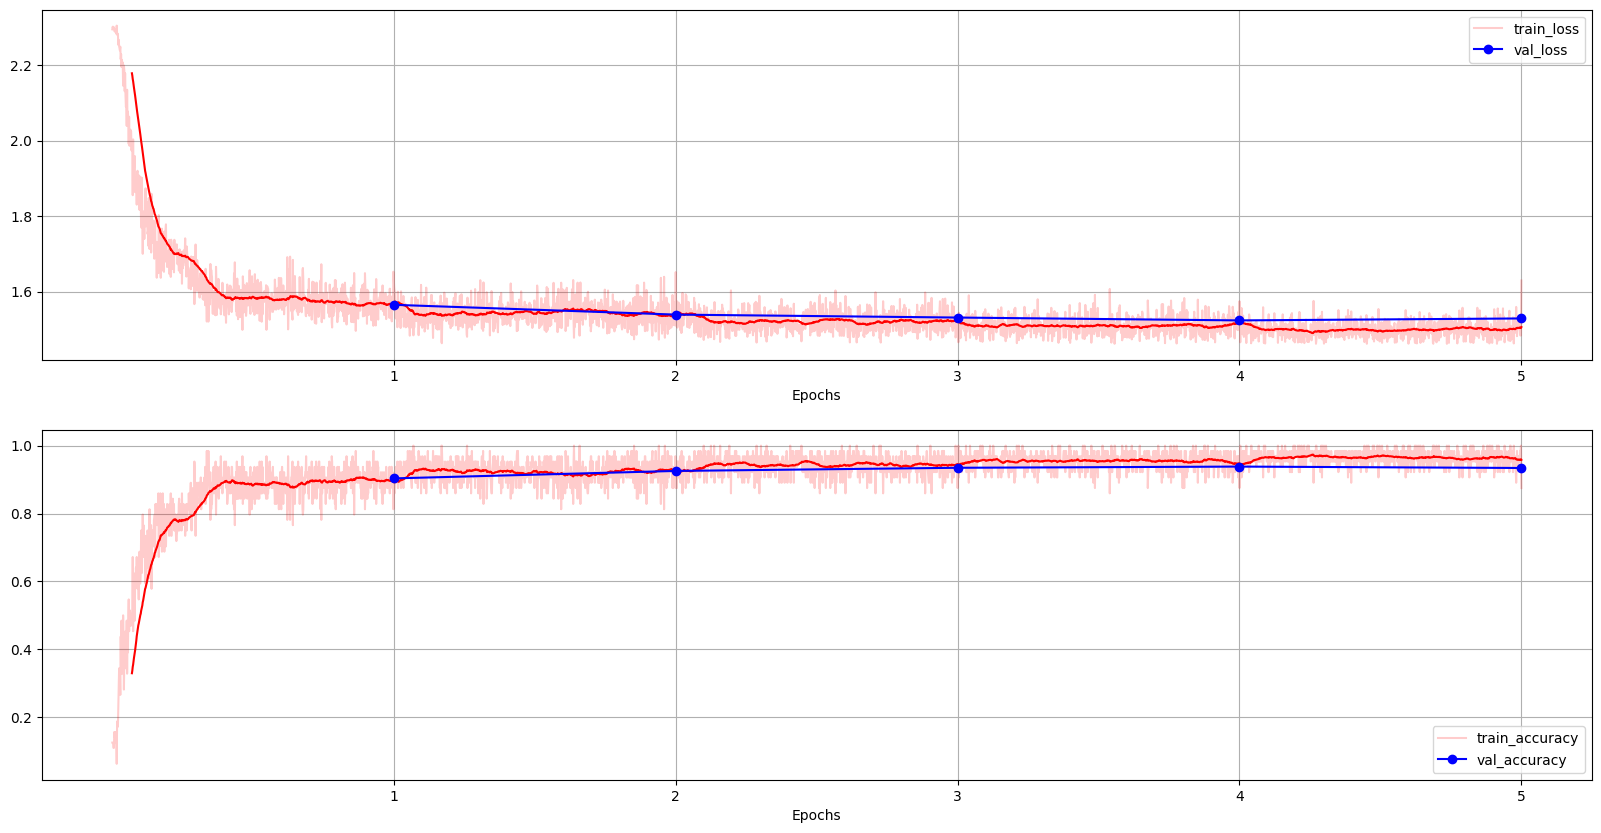

In [ ]:
plot_metrics(*training_app.get_metrics(), w=50)

### DenseNet

[DenseNet](https://arxiv.org/abs/1608.06993), short for Densely Connected Convolutional Networks, was introduced by **Gao Huang, Zhuang Liu, Laurens van der Maaten, and Kilian Q. Weinberger** in 2017. The network takes inspiration from the idea of skip connections introduced by the ResNet architecture and takes it to the next level.

The main ingredients of DenseNet are **dense blocks**, a collection of densely connected layers: each layer receives direct input from *all preceding layers*, applies a combination of batch-norm, Relu, and convolution/pooling, and passes its feature maps to all subsequent layers. In this way, the feature maps from all previous layers are concatenated, providing a rich set of features to each layer. To control the number of parameters and computational complexity, dense blocks can use **bottleneck layers**, consisting on a 1x1 convolution that reduces the number of channels before the 3x3 convolution. Using the terminology of the original paper, when the architecture includes these bottleneck layers, it is called DenseNet-B. The dense blocks are connected via **transition layers**, composed of 1x1 convolution followed by pooling, reducing the height and width of the feature maps. These transition layers can also shrink the number of channels by a given compression factor $\theta$, e.g. $\theta = 0.5$. When $\theta > 0$, the model is denoted as DenseNet-C. When both, bottleneck and compression, are present, the architecture is named DenseNet-BC.

Such a novel dense architecture comes with remarkable benefits compared to traditional methods, such as parameter efficiency (due to feature reuse) and mitigation of the vanishing gradient problem (as a consequence of including several skip connections).

Depending on the total number of layers, there are different DenseNet architectures. In here we use DenseNet-BC with 121 weight layers, which we denote as **DenseNet-121**.

<img src="./images_notebook/densenet.webp" width="600">

We load the pre-trained model from [torch's hub](https://pytorch.org/hub/pytorch_vision_densenet/) and use it in a wrapper class that keeps the pre-trained model's features but changes the final classifier layer. We fine-tune the model by updating all parameters during training.

For this last architecture we include a few more methods to the training process:

* We add a **scheduler**, which makes the learning rate decays every certain number of epochs, according to a pre-defined rule. In here we use a simple **step decay** rule, which multiplies the learning rate by a given constant factor every certain number of epochs. The decay factor and the frequency of the scheduler are two new hyperparameters.
* We use a new optimizer ... **[KG]**
* We include data agumentation transformations for the training set ... **[KG]**

After **[ADD TRAINING DETAILS]**

In [52]:
app_parameters = {'num_workers': 2,
                  'val_freq': 1,
                  'save_path': cwd + '/saved_models/densenet121_lr001',
                  'seed': 42}

hyperparameters = {'batch_size': 64,
                   'epochs': 20,
                   'model_parameters': {'drop_rate': 0.2},
                   'optimizer_parameters': {'lr': 0.01, 'momentum': 0.9, 'nesterov': True, 'weight_decay': 1e-4},
                   'scheduler_parameters': {'step_size':5, 'gamma':0.5}}

design = {'model': DenseNet121Wrapper,
          'criterion': nn.CrossEntropyLoss,
          'optimizer': optim.SGD,
          'scheduler': optim.lr_scheduler.StepLR}

transformation = {'train': trans_224imagenet_aug, 'val': trans_224imagenet}

training_app = CIFARTrainingApp(data_train,
                                data_val,
                                app_parameters,
                                hyperparameters,
                                transformation,
                                design)

print(f'\nModel: {training_app.model}')
n_parameters = np.sum([p.numel() for p in training_app.model.parameters()])
print(f'\nNumber of parameters: {n_parameters}\n')

print(f'\nCriterion: {training_app.criterion}')
print(f'\nOptimizer: {training_app.optimizer}')

Using cuda device
Random seed set as 42


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 129MB/s]



Model: DenseNet121Wrapper(
  (densenet121): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, 

In [ ]:
training_app.main(validate_bool=True, save_bool=True)
metrics_train_df, metrics_val_df = training_app.get_metrics()

Loading data...

Start training with 704/79 batches (trn/val) of size 64 for 20 epochs



Epoch 1/20: 100%|██████████| 704/704 [07:48<00:00,  1.50it/s, Loss = 1.606, Acc = 87.50%]

Val Loss: 1.618 Val Acc: 84.79% (Best) (0:08:05)

lr: 0.01


Epoch 2/20: 100%|██████████| 704/704 [07:51<00:00,  1.49it/s, Loss = 1.665, Acc = 75.00%]

Val Loss: 1.553 Val Acc: 91.30% (Best) (0:16:15)

lr: 0.01


Epoch 3/20: 100%|██████████| 704/704 [07:49<00:00,  1.50it/s, Loss = 1.501, Acc = 100.00%]

Val Loss: 1.539 Val Acc: 92.46% (Best) (0:24:23)

lr: 0.01


Epoch 4/20: 100%|██████████| 704/704 [07:52<00:00,  1.49it/s, Loss = 1.598, Acc = 100.00%]

Val Loss: 1.537 Val Acc: 92.56% (Best) (0:32:35)

lr: 0.01


Epoch 5/20: 100%|██████████| 704/704 [07:55<00:00,  1.48it/s, Loss = 1.810, Acc = 62.50%]

Val Loss: 1.552 Val Acc: 91.22% (0:40:51)

lr: 0.005


Epoch 6/20: 100%|██████████| 704/704 [07:59<00:00,  1.47it/s, Loss = 1.711, Acc = 75.00%]

Val Loss: 1.515 Val Acc: 94.72% (Best) (0:49:10)

lr: 0.005


Epoch 7/20: 100%|██████████| 704/704 [07:56<00:00,  1.48it/s, Loss = 1.461, Acc = 100.00%]

Val Loss: 1.514 Val Acc: 94.78% (Best) (0:57:28)

lr: 0.005


Epoch 8/20: 100%|██████████| 704/704 [07:54<00:00,  1.48it/s, Loss = 1.702, Acc = 75.00%]

Val Loss: 1.510 Val Acc: 95.33% (Best) (1:05:41)

lr: 0.005


Epoch 9/20: 100%|██████████| 704/704 [07:51<00:00,  1.49it/s, Loss = 1.467, Acc = 100.00%]



Val Loss: 1.511 Val Acc: 95.23% (1:13:53)

lr: 0.005


Epoch 10/20:  53%|█████▎    | 370/704 [04:11<03:48,  1.46it/s, Loss = 1.478, Acc = 98.44%]

## Inference Analysis

After this survey we found DenseNet with augmentation and Adam optimizer the best model, achieving **...%** accuracy on the validation set. The performance of the model must be reported using the unseen testset, which gives us an estimate of the **generalization error/accuracy**.

In this section we load such best model, run inference on the whole test set and store the predictions in a csv file. We then....

In [ ]:
model = ResNet50Wrapper()
model_device = next(model.parameters()).device

model_dict = torch.load(cwd + '/saved_models/resnet50_noreg_2024-01-13_17.03.28_best.state',
                   map_location=model_device)
state = model_dict['model_state']
trans_test = model_dict['transformations']['val']

model.load_state_dict(state)
model.eval();

Using cache found in /home/guybrush/.cache/torch/hub/pytorch_vision_v0.10.0
/home/guybrush/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/guybrush/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
dataset_test = CIFARDataset(data_test, transform=trans_test)
loader_test = DataLoader(dataset_test, batch_size=32, num_workers=0, shuffle=False)

In [ ]:
#test_df = test_model(loader_test, model, model_device)
#test_df.head(10)
test_df = pd.read_csv('test_df_resnet50.csv').drop(columns=['Unnamed: 0'])
test_df.head()

In [ ]:
df_confusion = pd.crosstab(test_df.labels, test_df.predictions, normalize='index')
df_confusion.index = df_confusion.columns = classes
accuracy = test_df['correct'].mean()*100

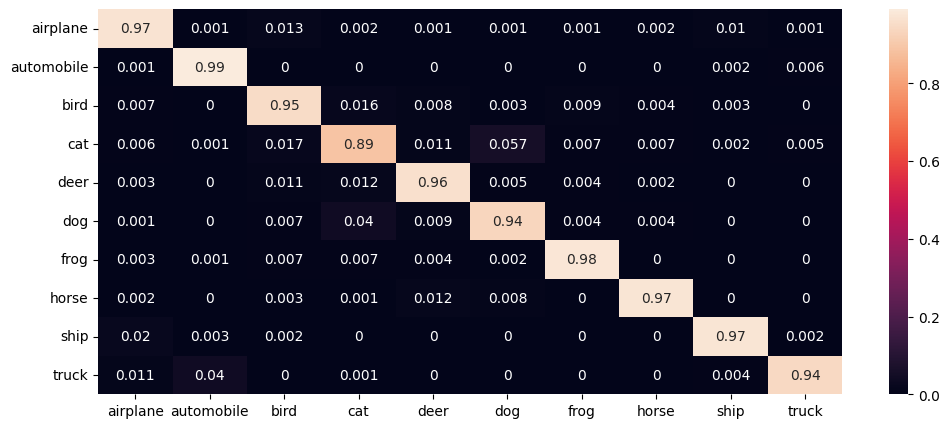

Total accuracy = 95.61%


In [ ]:
plt.figure(figsize=(12,5))
sns.heatmap(df_confusion, annot=True)
plt.show()
print(f'Total accuracy = {accuracy}%')

To display the incorrectly predicted images we use the index of the test dataframe because the set shuffle=False in the dataloader. Then, the images are passed in the same order always, from 0 to 9999.

In [ ]:
incorrect_df = test_df[test_df.correct==0].drop(columns='correct')

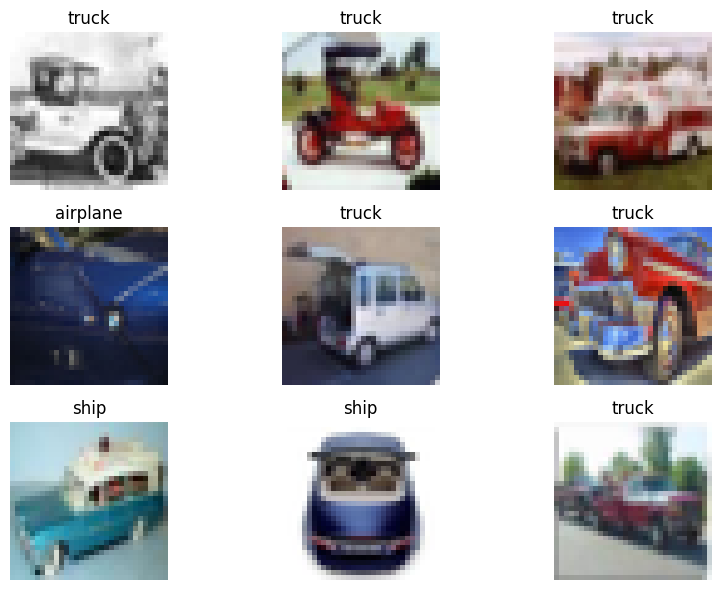

In [ ]:
cla = 1
incorrect_class = incorrect_df[incorrect_df['labels'] == cla]
imgs = data_test['imgs'][incorrect_class.index.to_list()]
predictions = np.expand_dims(incorrect_class['predictions'].to_numpy(), 1)
show_data(imgs, predictions)

## Conclusions

In this survey we studied different deep-learning architectures and methods for image classification using the CIFAR-10 dataset. The analysis followed a chronoligical order, in which subsequent models were more modern and complex than the previous one. We begun with a simple linear classifier, passed through classical CNNs, and ended up with a DenseNet architecture, which is widely used still today.

During such a journey, we convinced ourselves of the importance of using regularization and normalization techniques, data augmentation, modern optimizers, and learning rate decay. While, for pedagogical reasons these concepts where introduced progressively in the notebook, nowadays they constitute the starting point for any deep-learning model and so their inclussion is a must.

Obviously, this survey do not cover several other equally-relevant architectures. Not only those that came out after the discovery of DenseNet, such as [EfficientNet](https://arxiv.org/abs/1905.11946), but also before, e.g. [GoogLeNet](https://arxiv.org/abs/1409.4842v1).

## References
* [CNN for visual recognition (Stanford CS 231n)](https://cs231n.github.io/)
* [CNN cheatsheet (Stanford CS 229)](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks)
*[CNN Deeplearning.ai course video-lectures](https://www.youtube.com/playlist?list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF): Really nice! There is a week where all these CNN architectures are introduced and explained in detail.
* [DenseNet explained](https://amaarora.github.io/posts/2020-08-02-densenets.html)
* [Hugging Face tutorial](https://www.youtube.com/watch?v=00GKzGyWFEs&list=PLo2EIpI_JMQvWfQndUesu0nPBAtZ9gP1o&ab_channel=HuggingFace)
* [A lot of networks tested on CIFAR-10](https://github.com/kuangliu/pytorch-cifar)
* [Image classification on CIFAR-10 dataset benchmarks](https://paperswithcode.com/sota/image-classification-on-cifar-10)